In [1]:
import CUDA
using Knet
using CUDA: CUDA, CuArray
using Images
using ImageMagick
using ImageBinarization
using Random
using AutoGrad
using Statistics
import Base: length, size, iterate, eltype, IteratorSize, IteratorEltype, haslength, @propagate_inbounds, repeat, rand, tail
import .Iterators: cycle, Cycle, take
using IterTools: ncycle, takenth
using JLD2, FileIO
using PyPlot
using Clustering

# Hyperparameters

In [2]:
bs = 64;
resolution = 128; #16 for Baseline
decoder_res = 8;
slot_size = 64;
num_slots = 7;
num_iterations = 3;
hidden_dim = 64;

mlp_hidden_dim = 128;

array_type=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})

KnetArray{Float32,N} where N

# Data Loader

In [3]:
atype() = array_type
atype(x) = convert(atype(),x)

function load_image(filename)
    img = load(filename)
    img = img[29:221, 64:256]
    img = imresize(img, (resolution,resolution))
    img = Float32.(channelview(img))
    img = img[1:3,:,:]
    img = permutedims(img, [2, 3, 1])
    img = img .* 2 .- 1
end

struct CLEVR
    images
    batchsize::Int
    num_instances::Int
    shuffle::Bool
    function CLEVR(datasetPaths; batchsize::Int=32, shuffle::Bool=false)
        nFullBatches, rem = divrem(size(datasetPaths)[end], batchsize)
        new(datasetPaths[1:nFullBatches*batchsize], batchsize, nFullBatches*batchsize, shuffle)
    end
end

function length(d::CLEVR)
    nFullBatches, rem = divrem(d.num_instances, d.batchsize)
    nFullBatches + (rem > 0)*1
end

function iterate(d::CLEVR, state=ifelse(d.shuffle, randperm(d.num_instances), collect(1:d.num_instances)))
    if length(state) > 0
        imgBatch = load_image.(d.images[state[1:(length(state) < d.batchsize ? end : d.batchsize)]])
        batch = cat(imgBatch..., dims = 4)
        state  = state[d.batchsize+1:end]
        return atype(batch), state
    end
end

iterate (generic function with 463 methods)

In [4]:
atype() = array_type
atype(x) = convert(atype(),x)

function load_image(filename)
    img = load(filename)
    img = img[29:221, 64:256]
    img = imresize(img, (resolution,resolution))
    img = Float64.(channelview(img))
    img = img[1:3,:,:]
    img = permutedims(img, [2, 3, 1])
    img = img .* 2 .- 1
end

struct MaskFileDict
    files
    MaskFileDict(files) = new(files)
end
(c::MaskFileDict)(i) = (c.files[num_slots*(i-1)+1:num_slots*(i)])

function load_masks(filenames)
    msk = []
    i = 1
    for filename in filenames
#         print(filename)
        img = load(filename)
        img = img[29:221, 64:256]
        img = imresize(img, (resolution,resolution))
        img = Gray.(img)
        img = Float64.(channelview(img))
        img = img .* 2 .- 1
        img = reshape(img, (1,size(img)[1],size(img)[2]))
        msk = vcat(msk, img)
#         println(size(msk))
    end
    msk = permutedims(msk, [2, 3, 1])
    return msk
end

struct CLEVR_WITH_MASKS
    images
    masks
    batchsize::Int
    num_instances::Int
    shuffle::Bool
    function CLEVR_WITH_MASKS(datasetPaths, maskPaths; batchsize::Int=bs, shuffle::Bool=false)
        nFullBatches, rem = divrem(size(datasetPaths)[end], batchsize)
        masks = MaskFileDict(maskPaths)
        new(datasetPaths[1:nFullBatches*batchsize], masks, batchsize, nFullBatches*batchsize, shuffle)
    end
end

function length(d::CLEVR_WITH_MASKS)
    nFullBatches, rem = divrem(d.num_instances, d.batchsize)
    nFullBatches + (rem > 0)*1
end

function iterate(d::CLEVR_WITH_MASKS, state=ifelse(d.shuffle, randperm(d.num_instances), collect(1:d.num_instances)))
    if length(state) > 0
        imgBatch = load_image.(d.images[state[1:(length(state) < d.batchsize ? end : d.batchsize)]])
        filenames = d.masks.(state[1:(length(state) < d.batchsize ? end : d.batchsize)])
        permutedims(cat(filenames...,dims=2), [2,1])
        batch = cat(imgBatch..., dims = 4)
        masks = load_masks.(filenames)
        masks = cat(masks..., dims = 4)
        state  = state[d.batchsize+1:end]
        return (atype(batch), atype(masks)), state
    end
end

iterate (generic function with 465 methods)

In [5]:
trainDataPath = "//userfiles//ashah20//datasets//clevr_with_masks//clevr6//train//images"
files = readdir(trainDataPath);
filenames = files[endswith.(files, ".jpg")]
filenames = ["$(trainDataPath)//$(file)" for file in filenames];

clevrDataset = CLEVR(filenames, batchsize=bs, shuffle = true);

In [6]:
testDataPath = "//userfiles//ashah20//datasets//clevr_with_masks//clevr6//val//images"
tstfiles = readdir(testDataPath);
tstfilenames = tstfiles[endswith.(tstfiles, ".jpg")]
tstfilenames = ["$(testDataPath)//$(file)" for file in tstfilenames];

clevrDatasetTest = CLEVR(tstfilenames, batchsize=bs, shuffle = false);

In [7]:
l=2
testDataPath = "//userfiles//ashah20//datasets//clevr_with_masks//clevr6//val//images"
tstfiles = readdir(testDataPath);
tstfilenames = tstfiles[endswith.(tstfiles, ".jpg")]
tstfilenames = ["$(testDataPath)//$(file)" for file in tstfilenames];

testMasksPath = "//userfiles//ashah20//datasets//clevr_with_masks//clevr6//val//masks"
tstmasks = readdir(testMasksPath)
mskfilenames = tstmasks[endswith.(tstmasks, ".jpg")]
mskfilenames = ["$(testMasksPath)//$(file)" for file in mskfilenames];

mask_dataset = CLEVR_WITH_MASKS(tstfilenames, mskfilenames);

# Constructing the SlotAttentionModel

In [8]:
mutable struct Dense
    w
    b
    f
    p
    bias
end

function Dense(i::Int,o::Int;f=relu,pdrop=0, bias=true)
    w = param(o,i, atype = array_type)
    if(bias)
        b = param0(o, atype = array_type)
    else
        b = 0
    end
    Dense(w, b, f, pdrop, bias)
end

function (d::Dense)(x)
    if(d.bias)
        d.f.(d.w * mat(dropout(x,d.p)) .+ d.b)
    else
        d.f.(d.w * mat(dropout(x,d.p)))
    end
end

In [9]:
struct Conv; w; b; pad; f; p; end
(c::Conv)(x) = c.f.(conv4(c.w, dropout(x,c.p), padding=(c.pad,c.pad), stride=1) .+ c.b)
Conv(w1::Int,w2::Int,cx::Int,cy::Int,pad::Int; f=relu, pdrop=0) = Conv(param(w1,w2,cx,cy, atype = array_type), param0(1,1,cy,1, atype = array_type), pad, f, pdrop)

struct DeConv; w; b; f; p; pad; stride; end
(c::DeConv)(x) = c.f.(deconv4(c.w, dropout(x,c.p), padding=(c.pad,c.pad), stride=c.stride) .+ c.b)
DeConv(w1::Int,w2::Int,cx::Int,cy::Int;f=relu,pdrop=0, pad=1, stride=2) = DeConv(param(w1,w2,cy,cx, atype = array_type), param0(1,1,cy,1, atype = array_type), f, pdrop, pad, stride)

struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)

In [10]:
function outputCrop(x)
    return x[1:end-1, 1:end-1, :, :]
end

function flatten(x)
    batchsize = size(x)[end]
    return array_type(permutedims(reshape(x,(size(x)[1]*size(x)[2],hidden_dim,batchsize)),(2,1,3)))
end

function printdims(x)
    println(size(x))
   return x
end

function make3d_2d(x)
   return (reshape(x,(size(x)[1],size(x)[2]*size(x)[3])))
end

function inv_make3d_2d(x, shape)
   return (reshape(x,(shape[1],shape[2],shape[3])))
end



inv_make3d_2d (generic function with 1 method)

## Layer Normalization

In [11]:
# Layer Normalization
mutable struct LayerNorm; a; b; ϵ; dim; end 

"""
    LayerNorm(dmodel)
Creates an layer normalization layer. Inputs should be hidden vectors with hidden size of dmodel
Input shape: Tensor of arbitrary number of hidden vectors [dmodel, o...]
Output shape: Identical shape of [dmodel, o...]
"""
function LayerNorm(dmodel; dim=1, eps=1e-12, atype=atype())
    a = param(dmodel; init=ones, atype=atype)
    b = param(dmodel; init=zeros, atype=atype)
    LayerNorm(a, b, eps, dim)
end


function (l::LayerNorm)(x, o...)
    μ = mean(x,dims=l.dim)
    # Albert Implementation uses corrected == false when testing
    # Source: https://github.com/huggingface/transformers/blob/b592728eff9996e2cff1c5107438c4989aaa8149/src/transformers/models/albert/modeling_albert.py#L239 
    σ = std(x,mean=μ,dims=l.dim, corrected=false)
    ϵ = eltype(x)(l.ϵ)
    l.a .* (x .- μ) ./ (σ .+ ϵ) .+ l.b # TODO: doing x .- μ twice?
end

## Slot Attention Module

In [12]:
### now the slot attention module will get this encoded features matrix####
### input dimensions of this feature matrix is channel, hxw, batchsize

global_attn1 = zeros(num_slots, resolution*resolution, bs)
global_attn2 = zeros(num_slots, resolution*resolution, bs)
global_attn3 = zeros(num_slots, resolution*resolution, bs)

mutable struct SlotAttention
    num_iterations
    slot_size
    project_k
    project_v
    project_q
    gru
    mu
    log_sigma
    slot_mlp
    input_norm_layer
    slot_norm_layer
    mlp_norm_layer
end


function SlotAttention(num_iterations, slot_size, mlp_hidden_dim)
    project_k = Dense(slot_size, slot_size, bias=false)
    project_v = Dense(slot_size, slot_size, bias=false)
    project_q = Dense(slot_size, slot_size, bias=false)

    gru = RNN(slot_size, slot_size, rnnType=:gru, atype = array_type)
    
    mu = param(slot_size, 1, 1, atype=array_type)
    log_sigma = param(slot_size, 1, 1, atype=array_type)
    
    slot_mlp = Chain(Dense(slot_size, mlp_hidden_dim),
                    Dense(mlp_hidden_dim, slot_size, f=identity))
    
    input_norm_layer = LayerNorm(hidden_dim, atype=array_type)
    slot_norm_layer = LayerNorm(slot_size, atype=array_type)
    mlp_norm_layer = LayerNorm(slot_size, atype=array_type)
    
    return SlotAttention(num_iterations, slot_size, project_k, project_q, project_v, gru, mu, log_sigma, slot_mlp, input_norm_layer, slot_norm_layer, mlp_norm_layer)
end


attn_norm_factor = slot_size ^ -0.5
epsilon=1e-8


function (s::SlotAttention)(x)
    batchsize = size(x)[end]
#     println(size(x))
    encoded = permutedims(reshape(x,(size(x)[1]*size(x)[2],hidden_dim,batchsize)),(2,1,3))
    encoded = s.input_norm_layer(encoded)
    
    flattened_enc = make3d_2d(encoded)
#     println(size(flattened_enc))

    k = s.project_k(flattened_enc)
    k = inv_make3d_2d(k, size(encoded)) #shape = [slot_size, hxw, bs]

    v = s.project_v(flattened_enc)
    v = inv_make3d_2d(v, size(encoded)) #shape = [slot_size, hxw, bs]
    
    slots = s.mu .+ exp.(s.log_sigma) .* array_type(randn(s.slot_size, num_slots, batchsize))


    for i in 1:num_iterations
        prev_slots = slots
        prev_slots = make3d_2d(prev_slots)
        s.gru.h = prev_slots
        
        slots = s.slot_norm_layer(slots)
        slots = make3d_2d(slots)
        
        q = s.project_q(slots)
        q = reshape(q, (s.slot_size, num_slots, batchsize)) #shape = [slot_size, num_slots, bs]

        # batch matrix multiplication
        attn_logits = bmm(permutedims(q,(2, 1, 3)),(attn_norm_factor .* k))
        # softmax function
#         attn = exp.(attn_logits) ./ sum(exp.(attn_logits), dims=1) 
        attn = softmax(attn_logits, dims=1)

#         attn = attn .+ epsilon
        attn = attn ./ (sum(attn, dims=2) .+ epsilon)#shape = [num_slots, hxw, bs]
        
        if i == 1
            global global_attn1 = attn
        elseif i == 2
            global global_attn2 = attn
        elseif i == 3
            global global_attn3 = attn
        end
        
        updates = bmm(v, permutedims(attn,(2, 1, 3))) #shape = [slot_size, num_slots, bs]
        updates = make3d_2d(updates)
        
        slots = s.gru(updates) #shape = [slot_size, num_slots*bs]
#         slots = prev_slots
        slots = slots + s.slot_mlp(s.mlp_norm_layer(slots))
        slots = reshape(slots, (s.slot_size, num_slots, batchsize)) #shape = [slot_size, num_slots, bs]
        
    end
    
    return slots

end


In [13]:
function decoder_in_reshape(x)
    batchsize = size(x)[end]
    a = reshape(x, (1,1,slot_size, num_slots*batchsize))
    b = array_type(ones(decoder_res, decoder_res, slot_size, batchsize*num_slots))
    z = b .* a
   return z
end

function postprocess(decoder_out)
    decoder_out = reshape(decoder_out, (resolution, resolution, 4, num_slots, bs))

    recons = decoder_out[:,:,1:3,:,:]
    masks = decoder_out[:,:,4:4,:,:]
    masks = softmax(masks, dims=4)

    final_recons = reshape(sum(recons .* masks, dims=4), (resolution, resolution, 3, bs))
    return final_recons, recons, masks
end

postprocess (generic function with 1 method)

## Positional Embedding

In [14]:
add_dim(x::Array) = reshape(x, (size(x)...,1))

function build_grid(resolution)
    linspace1 = LinRange(0.0, 1.0, resolution[1])
    linspace2 = LinRange(0.0, 1.0, resolution[2])
    grid1 = (linspace1' .* ones(resolution[2]))'
    grid2 = (ones(resolution[1])' .* linspace2)'
    grid = cat(grid1,grid2; dims=3)
    grid = permutedims(grid, [3, 1, 2])
    grid = add_dim(grid)
    grid = cat(grid, 1 .- grid; dims=1)
    return grid
end


mutable struct SoftPositionEmbed
    dense
    grid
end

function SoftPositionEmbed(hidden_size::Int, resolution)
    dense  = Dense(4, hidden_size)
    grid = array_type(build_grid(resolution))
    return SoftPositionEmbed(dense, grid)
end

function (s::SoftPositionEmbed)(x)
    orig_grid_shape = size(s.grid)
    s.grid = reshape(s.grid,(size(s.grid)[1],size(s.grid)[2]*size(s.grid)[3]*size(s.grid)[4]))
    emb_proj = s.dense(s.grid)
    s.grid = reshape(s.grid,orig_grid_shape)
    emb_proj = reshape(emb_proj,(size(emb_proj)[1],orig_grid_shape[2],orig_grid_shape[3],orig_grid_shape[4]))
    emb_proj = permutedims(emb_proj, [2, 3, 1, 4])
    return x .+ emb_proj
end

## Model Initialization

In [15]:
Random.seed!(12345);

res = (resolution, resolution)
hidden_size = slot_size
encoder_pos_embed = SoftPositionEmbed(hidden_size, res)

encoder = Chain(Conv(5,5,3,hidden_dim,2),
                Conv(5,5,hidden_dim,hidden_dim,2),
                Conv(5,5,hidden_dim,hidden_dim,2),
                Conv(5,5,hidden_dim,hidden_dim,2),
                encoder_pos_embed,
                Conv(1,1,hidden_dim,hidden_dim,0),
                Conv(1,1,hidden_dim,slot_size,0, f=identity))

decoder =  Chain(DeConv(5,5,slot_size,hidden_dim),
                outputCrop,
                DeConv(5,5,hidden_dim,hidden_dim),
                outputCrop,
                DeConv(5,5,hidden_dim,hidden_dim),
                outputCrop,
                DeConv(5,5,hidden_dim,hidden_dim),
                outputCrop,
                DeConv(5,5,hidden_dim,hidden_dim, pad=2, stride=1),
                DeConv(3,3,hidden_dim,4, stride=1, f=identity))

dec_res = (decoder_res, decoder_res)
decoder_pos_embed = SoftPositionEmbed(hidden_size, dec_res)

SlotAttentionModel = Chain(encoder,
                        SlotAttention(num_iterations, slot_size, mlp_hidden_dim),
                        decoder_in_reshape,
                        decoder_pos_embed,
                        decoder,
                        postprocess);

In [16]:
params(SlotAttentionModel)

44-element Array{Param,1}:
 P(KnetArray{Float32,4}(5,5,3,64))
 P(KnetArray{Float32,4}(1,1,64,1))
 P(KnetArray{Float32,4}(5,5,64,64))
 P(KnetArray{Float32,4}(1,1,64,1))
 P(KnetArray{Float32,4}(5,5,64,64))
 P(KnetArray{Float32,4}(1,1,64,1))
 P(KnetArray{Float32,4}(5,5,64,64))
 P(KnetArray{Float32,4}(1,1,64,1))
 P(KnetArray{Float32,2}(64,4))
 P(KnetArray{Float32,1}(64))
 P(KnetArray{Float32,4}(1,1,64,64))
 P(KnetArray{Float32,4}(1,1,64,1))
 P(KnetArray{Float32,4}(1,1,64,64))
 ⋮
 P(KnetArray{Float32,4}(5,5,64,64))
 P(KnetArray{Float32,4}(1,1,64,1))
 P(KnetArray{Float32,4}(5,5,64,64))
 P(KnetArray{Float32,4}(1,1,64,1))
 P(KnetArray{Float32,4}(5,5,64,64))
 P(KnetArray{Float32,4}(1,1,64,1))
 P(KnetArray{Float32,4}(5,5,64,64))
 P(KnetArray{Float32,4}(1,1,64,1))
 P(KnetArray{Float32,4}(5,5,64,64))
 P(KnetArray{Float32,4}(1,1,64,1))
 P(KnetArray{Float32,4}(3,3,4,64))
 P(KnetArray{Float32,4}(1,1,4,1))

# Checking Forward Pass

In [17]:
function mse(predictions, targets)
    N = length(targets)
    y = 1/(2*N) * sum((predictions .- targets).^2)
    return y
end

mse (generic function with 1 method)

In [18]:
x = first(clevrDataset)
x = array_type(x)

final_recons, recons, masks = SlotAttentionModel(x);
error = mse(final_recons, x)

0.02203342318534851

In [19]:
function loss(model, input_batch)
    final_recons, recons, masks = model(input_batch)
    loss = mse(final_recons, input_batch)
    return loss
end

loss (generic function with 1 method)

In [20]:
# L = @diff loss(SlotAttentionModel, x)

# for p in params(SlotAttentionModel)
#     g = grad(L, p)
#     println(g)
# end

# Training

In [21]:
#@load "//kuacc//users//ashah20//slotattentionmodels//clevr//slotattention_v916_180.jld2"

In [22]:
# val_loss=0
# for testbatch in clevrDatasetTest
#     val_loss += loss(SlotAttentionModel, testbatch)
# end
# val_loss = val_loss ./ length(clevrDatasetTest)
# println(val_loss)

In [23]:
# #training hyperparameters
# num_epochs = 916
# base_learning_rate = 0.0004
# total_num_steps = length(clevrDataset) * num_epochs
# warmup_steps = 0.02 * total_num_steps
# decay_rate = 0.5
# decay_steps = 0.2 * total_num_steps

# # temporary variables
# current_step = 180 * length(clevrDataset)
# val_losses = zeros(num_epochs)
    
# for batch in ncycle(clevrDataset, num_epochs)
    
#     epoch = current_step/length(clevrDataset)
    
#     if (current_step % length(clevrDataset) == 0)
#         println(Int(epoch))
#         val_loss=0
#         for testbatch in clevrDatasetTest
#             val_loss += loss(SlotAttentionModel, testbatch)
#         end
#         val_loss = val_loss ./ length(clevrDatasetTest)
#         println(val_loss)
#     end
    
#     current_step+=1
    
#     if current_step < warmup_steps
#         learning_rate = base_learning_rate*(current_step/warmup_steps)
#     else
#         learning_rate = base_learning_rate*(decay_rate^(current_step/decay_steps))
#     end
    
#     adam!(loss, [(SlotAttentionModel, batch)], params=params(SlotAttentionModel), lr = learning_rate)
    
#     if (epoch % 30 == 0)
#         save_path = string("//kuacc//users//ashah20//slotattentionmodels//clevr//slotattention_v916_", Int(epoch), ".jld2")
#         @save save_path SlotAttentionModel
#     end
# end

In [24]:
# @save "slotattention_v916_2_full.jld2" SlotAttentionModel

# Sampling

In [25]:
input_samples = first(clevrDataset);

In [26]:
@load "//kuacc//users//ashah20//slotattentionmodels//clevr//slotattention_v916v6best_83.jld2"

┌ Warning: the following fields are present in type SlotAttention saved in the file but not present in the type the workspace:
│ 
│ num_slots,
│ 
│ Data in these fields will not be accessible
└ @ JLD2 /kuacc/users/ashah20/.julia/packages/JLD2/aRhgS/src/data.jl:442


1-element Array{Symbol,1}:
 :SlotAttentionModel

In [27]:
val_loss = 0
for testbatch in clevrDatasetTest
    val_loss += loss(SlotAttentionModel, testbatch)
end
val_loss = val_loss ./ length(clevrDatasetTest)
println(val_loss)

0.0005919752332071463


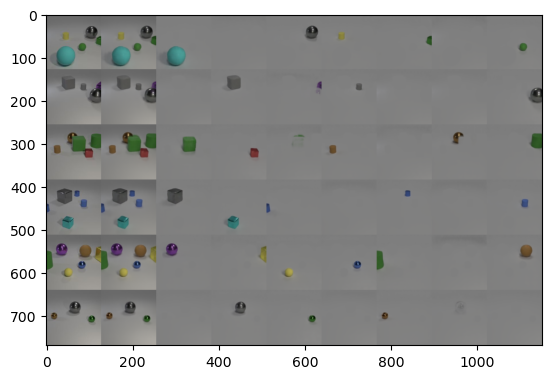

PyObject <matplotlib.image.AxesImage object at 0x2aecb91dafd0>

In [28]:
function displaySamples(input; num_samples = 6)
    in_sample = input
    in_sample = in_sample .* 0.5 .+ 0.5
    in_sample = in_sample .* (in_sample.>0)
    in_sample = in_sample .* (in_sample.<1)
    in_sample = Array{Float32}(in_sample);

    out_samples, slots_samples, masks_samples = SlotAttentionModel(input)
    out_samples = out_samples .* 0.5 .+ 0.5
    out_samples = out_samples .* (out_samples.>0)
    out_samples = out_samples .* (out_samples.<1)
    out_samples = Array{Float32}(out_samples);

    slots_recons = slots_samples.*masks_samples
    slots_recons = slots_recons .* 0.5 .+ 0.5
    slots_recons = slots_recons .* (slots_recons.>0)
    slots_recons = slots_recons .* (slots_recons.<1)
    slots_recons = Array{Float32}(slots_recons);
    
    image_row = cat(in_sample[:,:,:,1], out_samples[:,:,:,1], dims=2)
    for i in 1:num_slots
        image_row = cat(image_row, slots_recons[:,:,:,i,1], dims=2)
    end
    image_grid = image_row
    
    for i in 2:num_samples
        image_row = cat(in_sample[:,:,:,i], out_samples[:,:,:,i], dims=2)
        for j in 1:num_slots
            image_row = cat(image_row, slots_recons[:,:,:,j,i], dims=2)
        end
        image_grid = cat(image_grid, image_row, dims=1)
    end
    imshow(image_grid)
end


displaySamples(input_samples)

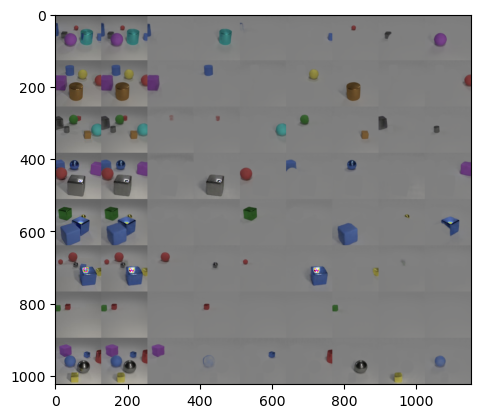

PyObject <matplotlib.image.AxesImage object at 0x2aedf9228310>

In [29]:
test_samples, masks = first(mask_dataset);
displaySamples(test_samples, num_samples=8)

In [31]:
alg = Otsu()

mask_encoder = ones(resolution,resolution*num_slots)
for i in 1:num_slots
    mask_encoder[:,(i-1)*resolution+1:(i)*resolution] = mask_encoder[:,(i-1)*resolution+1:(i)*resolution] .* i
end

function evaluate_image(img_index, masks_disp, msks)
    image_row = masks_disp[:,:,1,img_index]
    orig_msks = msks[:,:,1,img_index] .* 0.0 .-1
    for i in 2:num_slots
        image_row = cat(image_row, masks_disp[:,:,i,img_index], dims=2)
        orig_msks = cat(orig_msks, msks[:,:,i,img_index], dims=2)
    end
    binarized = binarize(image_row, alg)
    orig_msks = (orig_msks .+ 1) ./ 2
    
    encodedmasksfull1 = binarized.*mask_encoder
    encodedmasksfull2 = binarize(orig_msks, alg) .* mask_encoder
    enc_masks1 = zeros(resolution,resolution)
    enc_masks2 = zeros(resolution,resolution)
    for i in 1:num_slots
        enc_masks1 += encodedmasksfull1[:,(i-1)*resolution+1:(i)*resolution]
        enc_masks2 += encodedmasksfull2[:,(i-1)*resolution+1:(i)*resolution]
    end
    
    enc_masks1 = Int.(floor.(reshape(enc_masks1,(resolution*resolution))))
    enc_masks2 = Int.(floor.(reshape(enc_masks2,(resolution*resolution))));
    
    return randindex(enc_masks1, enc_masks2)[l]
end

function evaluate_batch(imgs, msks)
    msks = Array{Float32}(msks)

    out_samples, slots_samples, masks_samples = SlotAttentionModel(imgs)
    masks_pred = reshape(masks_samples, (resolution, resolution, num_slots, bs))
    
    masks_disp = masks_pred .* 0.5 .+ 0.5
    masks_disp = masks_disp .* (masks_disp.>0)
    masks_disp = masks_disp .* (masks_disp.<1)
    masks_disp = Array{Float32}(masks_disp)
    
    ari = 0
    
    for img_index in 1:bs
        ari +=evaluate_image(img_index, masks_disp, msks)
    end
    
    return ari/bs
    
end

evaluate_batch (generic function with 1 method)

In [32]:
aritotal = 0
val_loss = 0
for (imgs_batch, msks_batch) in mask_dataset
    aritotal += evaluate_batch(imgs_batch, msks_batch)
    val_loss += loss(SlotAttentionModel, imgs_batch)
end
val_loss = val_loss ./ length(mask_dataset)
println(val_loss)
println(aritotal/length(mask_dataset))

0.0006483489104236165
0.9710298125257658


In [55]:
test_samples, masks = first(mask_dataset);
in_sample = test_samples
in_sample = in_sample .* 0.5 .+ 0.5
in_sample = in_sample .* (in_sample.>0)
in_sample = in_sample .* (in_sample.<1)
in_sample = Array{Float32}(in_sample);

out_samples, slots_samples, masks_samples = SlotAttentionModel(test_samples)
out_samples = out_samples .* 0.5 .+ 0.5
out_samples = out_samples .* (out_samples.>0)
out_samples = out_samples .* (out_samples.<1)
out_samples = Array{Float32}(out_samples);

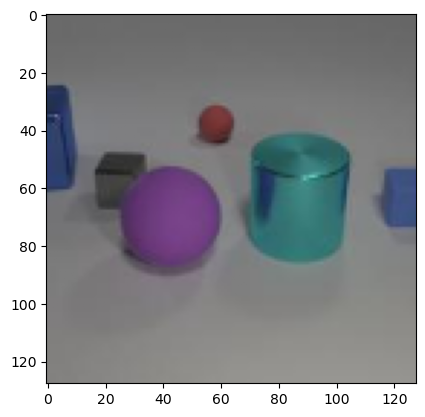

PyObject <matplotlib.image.AxesImage object at 0x2aede6001dc0>

In [89]:
spl = 1
imshow(in_sample[:,:,:,spl])

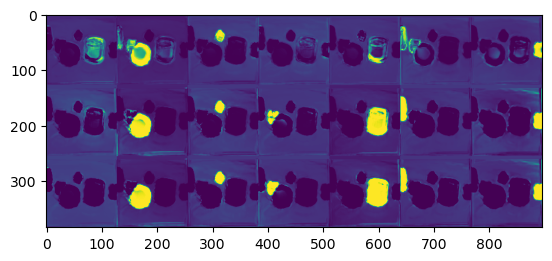

PyObject <matplotlib.image.AxesImage object at 0x2aede61ef3a0>

In [90]:
map1 = Array{Float32}(reshape(global_attn1[:,:,spl], (num_slots, resolution, resolution)))
map1 = map1./sum(map1, dims = 1)

map2 = Array{Float32}(reshape(global_attn2[:,:,spl], (num_slots, resolution, resolution)))
map2 = map2./sum(map2, dims = 1)

map3 = Array{Float32}(reshape(global_attn3[:,:,spl], (num_slots, resolution, resolution)))
map3 = map3./sum(map3, dims = 1)

attnrow1 = map1[1,:,:]
attnrow2 = map2[1,:,:]
attnrow3 = map3[1,:,:]
for i in 2:num_slots
    attnrow1 = cat(attnrow1, map1[i,:,:], dims=2)
    attnrow2 = cat(attnrow2, map2[i,:,:], dims=2)
    attnrow3 = cat(attnrow3, map3[i,:,:], dims=2)
end

attnmasks = cat(attnrow1, attnrow2, attnrow3, dims=1);

imshow(attnmasks)